In [1]:
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
%matplotlib notebook
from main import *

In [2]:
#Extracting the SS coverages previously saved and extracted from kMC files
ss_COVG_NONLAT = pd.read_csv('SS_Covg_nonLat.csv')
ss_COVG_LAT = pd.read_csv('SS_Covg_Lat.csv')

In [3]:
#Isolating pressures and ss coverages
Prs_non_lat = ss_COVG_NONLAT.iloc[:,0].to_numpy()
Prs_lat = ss_COVG_LAT.iloc[:,0].to_numpy()
ss_covg_non_lat = ss_COVG_NONLAT.iloc[:,1].to_numpy()
ss_covg_lat = ss_COVG_LAT.iloc[:,1].to_numpy()

In [4]:
#Simulation times from each kMC simulation
t0,tf = 0,750.000000000102

In [5]:
%%time
#Performing SS MIKI MKM simulations for non lateral case
from main import *
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.Thermo_Constraint = 'OFF'
MKM.set_limits_of_integration(t0,tf)
MKM.rate_const_correction='None'
MKM_SS_covg_NONLAT = []
Prs = Prs_non_lat
for i in np.arange(len(Prs)):
    MKM.set_rxnconditions(Pr=[Prs[i]])
    MKM_SS_covg_NONLAT = np.append(MKM_SS_covg_NONLAT,MKM.get_SS_coverages(print_warning=False)[0])

Mass is conserved. 

CPU times: user 2.77 s, sys: 15.9 ms, total: 2.78 s
Wall time: 2.79 s


<IPython.core.display.Javascript object>


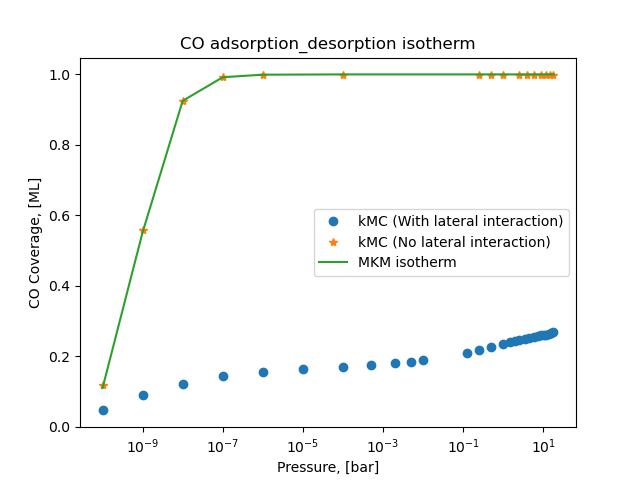

In [6]:
plt.figure()
plt.semilogx(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.semilogx(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.semilogx(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
# plt.semilogx(Prs,MKM_SS_covg_LAT,'-',label='MKM isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()

In [7]:
# For lateral only
##Step 1: Calculating Ki based on isotherm equation
Ki_lateral = []
for i in np.arange(len(Prs_lat)):
    Ki_lateral.append(ss_covg_lat[i]/((1-ss_covg_lat[i]) * Prs_lat[i]))
    
##Step 2: Calculating fi(theta)
Keq = MKM.k[0]/MKM.k[1]
fi_theta = []
for i in np.arange(len(Prs_lat)):
    fi_theta.append(Ki_lateral[i]/Keq)
    
##Therefore need to train ML model (for lateral interactions considered) where x is theta and y is fi_theta
##Step 3: MLM model
print('For Lateral:\n')
print('Pressure, SS_coverage_CO, K_from_isoeqn, f(theta)')
print(np.array([Prs_lat,ss_covg_lat,Ki_lateral,fi_theta]).T)

For Lateral:

Pressure, SS_coverage_CO, K_from_isoeqn, f(theta)
[[1.00000000e-10 4.63296155e-02 4.85803232e+08 3.94275087e-01]
 [1.00000000e-09 9.11109711e-02 1.00244329e+08 8.13577165e-02]
 [1.00000000e-08 1.21996393e-01 1.38947485e+07 1.12768973e-02]
 [1.00000000e-07 1.43216148e-01 1.67155517e+06 1.35662448e-03]
 [1.00000000e-06 1.55425457e-01 1.84028110e+05 1.49356148e-04]
 [1.00000000e-05 1.63325156e-01 1.95207442e+04 1.58429228e-05]
 [1.00000000e-04 1.70388884e-01 2.05384042e+03 1.66688498e-06]
 [5.00000000e-04 1.75406734e-01 4.25438192e+02 3.45283170e-07]
 [2.00000000e-03 1.80016145e-01 1.09768104e+02 8.90871566e-08]
 [5.00000000e-03 1.84291328e-01 4.51855752e+01 3.66723509e-08]
 [1.00000000e-02 1.88856113e-01 2.32826895e+01 1.88960958e-08]
 [1.25000000e-01 2.08986241e-01 2.11360411e+00 1.71538884e-09]
 [2.50000000e-01 2.17408512e-01 1.11122350e+00 9.01862547e-10]
 [5.00000000e-01 2.25479268e-01 5.82242045e-01 4.72544269e-10]
 [1.00000000e+00 2.34419844e-01 3.06198955e-01 2.48509

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicRegressor
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sympy import *
from sklearn.utils.random import check_random_state
import graphviz
import time

In [9]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(np.array(Ki_lateral).reshape(-1, 1))
# Ki_lateral = scaler.transform(np.array(Ki_lateral).reshape(-1, 1))
# data = np.array([ss_covg_lat, Ki_lateral[:,0]]).T
# columns = ['theta', 'Ki']
# df = pd.DataFrame(data = data, columns = columns)
# df.head()


data = np.array([ss_covg_lat, Ki_lateral]).T
columns = ['theta', 'Ki']
df = pd.DataFrame(data = data, columns = columns)
df.head()

,theta,Ki
0,0.046330,4.858032e+08
1,0.091111,1.002443e+08
2,0.121996,1.389475e+07
3,0.143216,1.671555e+06
4,0.155425,1.840281e+05


<IPython.core.display.Javascript object>


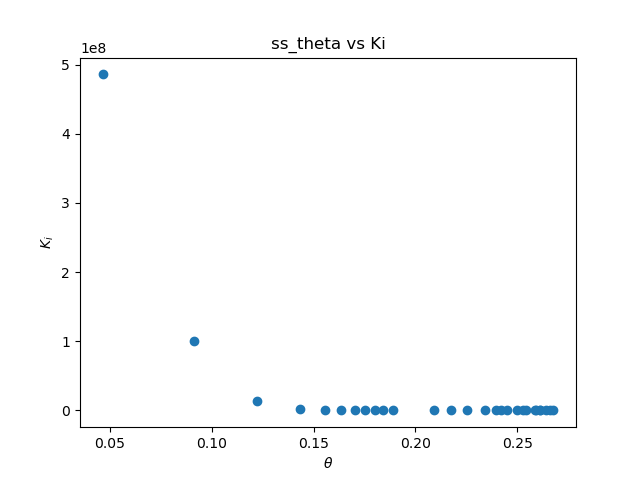

Text(0.5, 0, '$\\theta$')

In [10]:
plt.figure(dpi = 100)
plt.title('ss_theta vs Ki')
plt.scatter(df['theta'], df['Ki'])
plt.ylabel(r'$K_i$')
plt.xlabel(r'$\theta$')

In [11]:
X = df[['theta']]
y = df['Ki']
y_true = y
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler
# scaler = MinMaxScaler()
# # scaler = StandardScaler()
# # Fit the scaler to the features
# scaler.fit(X_train)
# # Transform the features
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
# y_train = scaler.transform(np.array(y_train).reshape(-1, 1))
# y_test = scaler.transform(np.array(y_test).reshape(-1, 1))

# X_train = pd.DataFrame(X_train)
# X_test = pd.DataFrame(X_test)
# y_train = pd.DataFrame(y_train)
# y_test = pd.DataFrame(y_test)

((22, 1), (6, 1), (22,), (6,))

In [12]:
def ML_model(algorithm="XGBoost", X_train = X_train, Y_train = y_train):
    
    #XGBoost Algorithm
    #https://xgboost.readthedocs.io/en/stable/python/python_api.html
    if algorithm=="XGBoost":  
        import xgboost as xgb

        reg = xgb.XGBRegressor(booster='gbtree',    
                               n_estimators=15000,
                               objective='reg:squarederror',
                               max_depth=20,
                               learning_rate=0.01)
        reg.fit(X_train, Y_train,
                eval_set=[(X_train, Y_train)],
                verbose=False)
    
    #Artificial Neural Network
    #https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor
    elif algorithm=="ANN":
        from sklearn.neural_network import MLPRegressor
        No_H_nodes_per_layer = 4
        print('Number of Hidden layer nodes per layer : ',No_H_nodes_per_layer)
        No_H_layers = 3
        print('Number of Hidden layers: ',No_H_layers)

        hidden_layers = No_H_nodes_per_layer*np.ones(No_H_layers) 
        hidden_layer_sizes = tuple(tuple(int(item) for item in hidden_layers))
        reg = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                            activation='relu', 
                            solver='adam')
#                            ,random_state=42, 
#                             max_iter=300)

        reg.fit(X_train, Y_train)
    
    #K-Nearest Neighbor
    #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
    elif algorithm=="KNN":
        from sklearn.neighbors import KNeighborsRegressor

        reg = KNeighborsRegressor(n_neighbors=2, weights='distance',p=2)
        reg.fit(X_train, Y_train)
    
    #RandomForest 
    #https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
    elif algorithm=='RandomForest':
        from sklearn.ensemble import RandomForestRegressor
        
        reg = RandomForestRegressor(n_estimators=100000, criterion='poisson',random_state=24)

        reg.fit(X_train, Y_train)
        
        print('Features:',X_train.columns)
        
        print('\nFeature Importance:\n',reg.feature_importances_) #Shows which features are chosen most when doing splits #gives the most information
        
    elif algorithm=='DecisionTree':
        from sklearn import tree
        reg = tree.DecisionTreeRegressor()#criterion='poisson',max_depth=20,min_samples_leaf=10,min_samples_split=20
        
        reg.fit(X_train, Y_train)
        
        print('Features:',X_train.columns)
        
        print('\nFeature Importance:\n',reg.feature_importances_) #Shows which features are chosen most when doing splits #gives the most information

    return reg

In [13]:
import time
######### OPTIONS: 'XGBoost','ANN','KNN','RandomForest'#########
################################################################
ALGORITHM_NAME = "RandomForest"
################################################################

start_time = time.time()
reg = ML_model(algorithm = 'RandomForest')
end_time = time.time()

elapsed_time = end_time - start_time
print("\nElapsed Model Training Time: \n", elapsed_time, "seconds \n", elapsed_time/60, "minutes")

Number of Hidden layer nodes per layer :  4
Number of Hidden layers:  3

Elapsed Model Training Time: 
 0.06236696243286133 seconds 
 0.001039449373881022 minutes


/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [14]:
Y_output = reg.predict(X_test)
Y_output

array([2.60601403, 2.65214265, 2.60354346, 2.64899484, 2.52628811,
       2.62515193])

In [15]:
y_test

9     4.518558e+01
25    2.563623e-02
8     1.097681e+02
21    4.652298e-02
0     4.858032e+08
12    1.111223e+00
Name: Ki, dtype: float64

In [16]:
from math import sqrt
from sklearn.metrics import mean_squared_error
#Calculating the root mean squared of the test set
print('Root Mean Squared Error:\n',sqrt(mean_squared_error(Y_output, y_test)))

Root Mean Squared Error:
 198328338.10041174


In [17]:
%%time
#Performing SS MIKI MKM simulations for lateral case
from main import *
MKMCD = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKMCD.Thermo_Constraint = 'OFF'
MKMCD.set_limits_of_integration(t0,tf)
colmn = len(MKMCD.Stoich.iloc[0,1:]) - len(MKMCD.P) #Number of columns (i.e rate coefficients = no. of surface species being investigated)
row = len(MKMCD.k) #number of rows = number of rate constants (i.e reaction steps)
MKM_SS_covg_LAT = []
Prs = Prs_lat #Lateral pressures## TO BE PREDICTED###########################################################
for i in np.arange(len(Prs)):
    MKMCD.set_rxnconditions(Pr=[Prs[i]])
    MKM_SS_covg_LAT = np.append(MKM_SS_covg_LAT,MKMCD.get_SS_coverages(print_warning=True)[0])    

Mass is conserved. 

Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
CPU times: user 4.84 s, sys: 38.9 ms, total: 4.87 s
Wall time: 4.87 s


In [18]:
##Step 4-> Getting predicted _f(theta)
input_ = np.array([MKM_SS_covg_LAT]).T
Ki_lateral_pred = reg.predict(input_)

##Step5-> Calculating predicted theta
ML_theta_pred = []
for i in np.arange(len(Prs)):
    ML_theta_pred.append((Ki_lateral_pred[i]*Prs[i])/(1+(Ki_lateral_pred[i]*Prs[i])))

/Users/klkusima/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


In [19]:
print('Root Mean Squared Error:\n',sqrt(mean_squared_error(ss_covg_lat, ML_theta_pred)))

Root Mean Squared Error:
 0.49104464565726657304514265058983973907616236685791


<IPython.core.display.Javascript object>


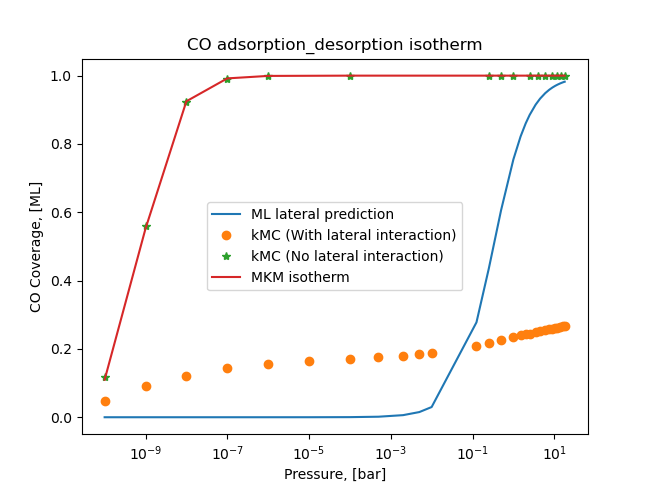

In [20]:
plt.figure()
plt.semilogx(Prs,ML_theta_pred,'-',label='ML lateral prediction')
plt.semilogx(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.semilogx(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.semilogx(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
# plt.semilogx(Prs,MKM_SS_covg_LAT,'-',label='MKM isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()

<IPython.core.display.Javascript object>


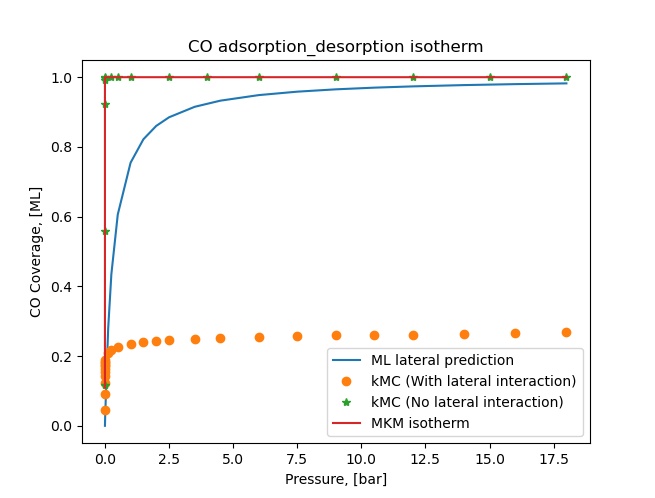

In [21]:
plt.figure()
plt.plot(Prs,ML_theta_pred,'-',label='ML lateral prediction')
plt.plot(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.plot(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.plot(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
# plt.semilogx(Prs,MKM_SS_covg_LAT,'-',label='MKM isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()

In [22]:
##Step4: Return model based on 